# Analyzing the reduced KCWI cubes

In [2]:
import numpy as np
import warnings

from spectral_cube import SpectralCube

from astropy.io import fits
from astropy.table import Table
from astropy.stats import sigma_clipped_stats
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS, utils as wcsutils
from astropy import units as u, visualization as vis
from astropy.nddata import NDDataArray, StdDevUncertainty, NDData

from photutils.aperture import SkyEllipticalAperture, EllipticalAperture

from scipy.interpolate import interp1d

import pyregion as pyreg

import matplotlib.pyplot as plt

from frb.analysis import kcwi
from spectral_cube import utils as scutils
from importlib import reload

# KCWIDatacube class

## Instantiation and Attributes

In [3]:
kcwi.silence_warnings(scutils.PossiblySlowWarning) # Get rid of the annoying "datacube may be too big" warnings

In [14]:
reload(kcwi)

<module 'frb.analysis.kcwi' from '/home/sunil/Python/FRB/frb/analysis/kcwi.py'>

In [51]:
# Instantiate on PypeIt cube
blue_file = "KCWI/redux/keck_kcwi_D/Science_cube/FRB20250316A_kcwi_stack_wcs.fits"
blue_cube = kcwi.KCWIDatacube(blue_file, reduction_pipeline='pypeit')
# Data
blue_cube.cube

SpectralCube with shape=(4676, 58, 59):
 n_x:     59  type_x: RA---TAN  unit_x: deg    range:   182.428623 deg:  182.439197 deg
 n_y:     58  type_y: DEC--TAN  unit_y: deg    range:    58.846288 deg:   58.851662 deg
 n_s:   4676  type_s: WAVE      unit_s: Angstrom  range:     3379.275 Angstrom:    6005.678 Angstrom

In [20]:
# Fits header of the flux data
blue_cube.cube.header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    3                                                  
NAXIS1  =                   59                                                  
NAXIS2  =                   58                                                  
NAXIS3  =                 4676                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
FLUXUNIT= '1e-17 erg / (Angstrom cm2 s)' / Flux units -- erg/s/cm^2/Angstrom/arc
DMODCLS = 'DataCube'           / Datamodel class                                
DMODVER = '1.2.0   '           / Datamodel version                              
PYP_SPEC= 'keck_kcwi'                                                           
FLUXED  =                   

In [9]:
# To access raw data
blue_cube.cube.unmasked_data[:]

<Quantity [[[0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.],
            ...,
            [0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.]],

           [[0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.],
            ...,
            [0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.]],

           [[0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.],
            ...,
            [0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.]],

           ...,

           [[0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.],
            ...,
      

In [10]:
# To access masked data
np.any(np.isnan(blue_cube.cube.filled_data[:])) # Fill value is nan so, just going to check this.

True

In [11]:
# Variance
blue_cube.varcube

SpectralCube with shape=(4676, 58, 59):
 n_x:     59  type_x: RA---TAN  unit_x: deg    range:   182.428623 deg:  182.439197 deg
 n_y:     58  type_y: DEC--TAN  unit_y: deg    range:    58.846288 deg:   58.851662 deg
 n_s:   4676  type_s: WAVE      unit_s: Angstrom  range:     3379.275 Angstrom:    6005.678 Angstrom

In [12]:
# Wavelength grid
blue_cube.cube.spectral_axis

<Quantity [3379.27464088, 3379.83643836, 3380.39823583, ..., 6004.55424157,
           6005.11603904, 6005.67783652] Angstrom>

In [13]:
# WCS
blue_cube.cube.wcs

WCS Keywords

Number of WCS axes: 3
CTYPE : 'RA---TAN'  'DEC--TAN'  'WAVE'  
CRVAL : 182.4340924315567  58.848928042906614  3.3787128434094997e-07  
CRPIX : 29.0  29.0  0.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : -9.4295e-05  9.4295e-05  5.6179747500119e-11  
NAXIS : 59  58  4676

## Methods

In [16]:
reload(kcwi)

<module 'frb.analysis.kcwi' from '/home/sunil/Python/FRB/frb/analysis/kcwi.py'>

### Tile spectral array

In [22]:
# Tile spectral-shaped arrays along spatial axes 
array_to_be_tiled = np.arange(len(blue_cube.cube.spectral_axis))
print(blue_cube._spectral_tile(array_to_be_tiled).shape)
blue_cube._spectral_tile(array_to_be_tiled)

(4676, 58, 59)


array([[[   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0],
        ...,
        [   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0]],

       [[   1,    1,    1, ...,    1,    1,    1],
        [   1,    1,    1, ...,    1,    1,    1],
        [   1,    1,    1, ...,    1,    1,    1],
        ...,
        [   1,    1,    1, ...,    1,    1,    1],
        [   1,    1,    1, ...,    1,    1,    1],
        [   1,    1,    1, ...,    1,    1,    1]],

       [[   2,    2,    2, ...,    2,    2,    2],
        [   2,    2,    2, ...,    2,    2,    2],
        [   2,    2,    2, ...,    2,    2,    2],
        ...,
        [   2,    2,    2, ...,    2,    2,    2],
        [   2,    2,    2, ...,    2,    2,    2],
        [   2,    2,    2, ...,    2,    2,    2]],

       ...,

       [[4673, 4673, 467

### Wavelength mask

In [64]:
# Mask out wavelengths
wavemask_1d = ((blue_cube.cube.spectral_axis>3500*u.AA)&(blue_cube.cube.spectral_axis<3700*u.AA))| \
           ((blue_cube.cube.spectral_axis>4500*u.AA)&(blue_cube.cube.spectral_axis<4700*u.AA))

masked_cube, masked_varcube = blue_cube.wave_mask(wavemask_1d)

In [65]:
unmasked_pixnum_orig = np.sum(blue_cube.cube.mask.include()) # Original mask from pypeit
unmasked_pixnum_orig

6637932

In [66]:
unmasked_pixnum_wave = np.sum(masked_cube.mask.include()) # Additional wavelength mask applied
unmasked_pixnum_wave

1074598

In [67]:
unmasked_pixnum_orig>unmasked_pixnum_wave

True

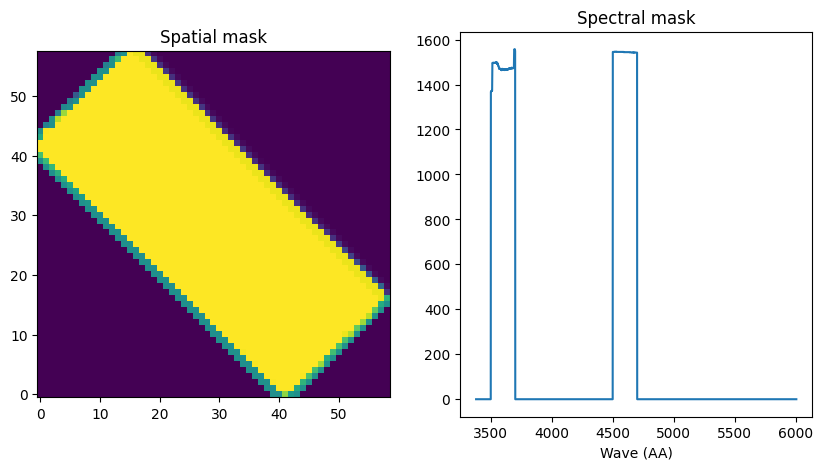

In [71]:
fig, axs = plt.subplots(1, 2, figsize = (10,5))
ax = axs[0]
ax.imshow(np.sum(masked_cube.mask.include(), axis=0))
ax.invert_yaxis()
ax.set_title("Spatial mask")

ax = axs[1]
ax.plot(blue_cube.cube.spectral_axis.value, np.sum(masked_cube.mask.include(), axis=(1,2)))
ax.set_title("Spectral mask")
ax.set_xlabel("Wave (AA)")
plt.show()

### Create an image by applying a transmission curve

In [6]:
reload(kcwi)

<module 'frb.analysis.kcwi' from '/home/sunil/Python/FRB/frb/analysis/kcwi.py'>

In [7]:
# Find a suitable transmission curve file. The FRB repo has some in its database

# Test the creation of the interpolator function
transfile = "/home/sunil/Python/FRB/frb/data/analysis/CIGALE/DECaL_g.dat"
trans = kcwi._interp_trans(transfile, format="ascii.no_header", comment="#")
trans

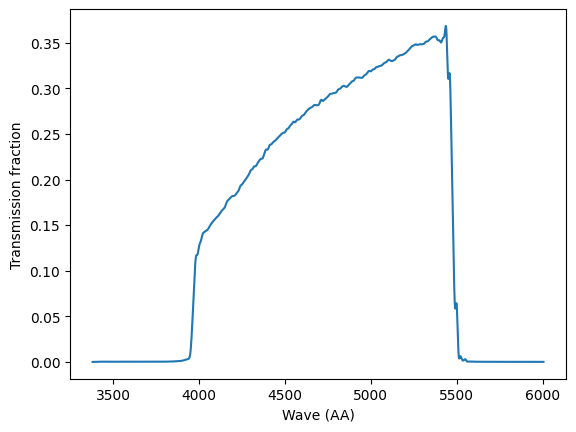

In [8]:
wave = blue_cube.cube.spectral_axis.value
plt.plot(wave, trans(wave))
plt.xlabel("Wave (AA)")
plt.ylabel("Transmission fraction")
plt.show()

/home/sunil/miniconda3/lib/python3.12/site-packages/astropy/stats/sigma_clipping.py:407: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
  warnings.warn(


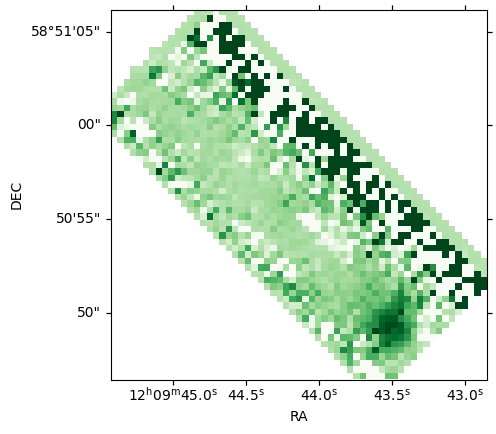

In [12]:
# Now test making an image
synthetic_decal_g = blue_cube.get_img( trans_readkw={'format':"ascii.no_header", 'comment':"#"})
_, med, std = sigma_clipped_stats(synthetic_decal_g, maxiters=20, sigma_upper=2)
norm = vis.ImageNormalize(stretch = vis.LinearStretch(), vmin=med-5*std, vmax=med+10*std)
fig, ax = plt.subplots(1,1,subplot_kw={'projection':synthetic_decal_g.wcs})
plt.imshow(synthetic_decal_g.array, norm=norm, cmap="Greens")
plt.show()

### Narrow band image from line emission

In [52]:
blue_cube.cube.meta

{'reduction_pipeline': 'pypeit',
 'datafile': '/home/sunil/Desktop/FRB/250316/KCWI/redux/keck_kcwi_D/Science_cube/FRB20250316A_kcwi_stack_wcs.fits',
 'fluxunit': <Quantity 1.e-17 erg / (Angstrom s cm2)>}

/home/sunil/miniconda3/lib/python3.12/site-packages/astropy/stats/sigma_clipping.py:407: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
  warnings.warn(


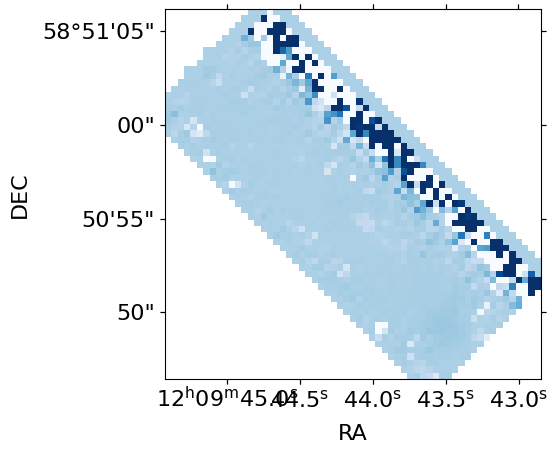

In [54]:
white_light = blue_cube.get_img()
_, med, std = sigma_clipped_stats(white_light)
norm = vis.ImageNormalize(stretch = vis.LinearStretch(), vmin=med-5*std, vmax=med+10*std)
fig, ax = plt.subplots(1,1,subplot_kw={'projection':white_light.wcs})
plt.imshow(white_light.array, norm=norm, cmap="Blues")
plt.show()

/home/sunil/miniconda3/lib/python3.12/site-packages/astropy/stats/sigma_clipping.py:407: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
  warnings.warn(


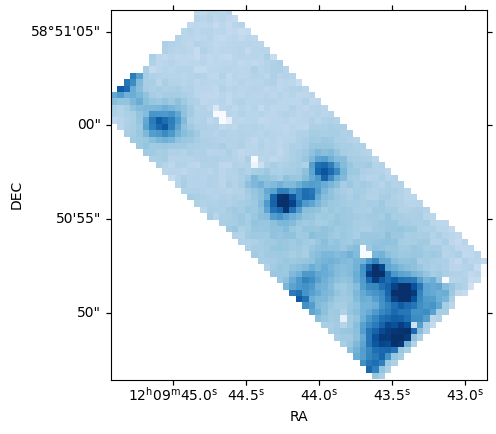

In [16]:
#wavemask_1d = ((blue_cube.cube.spectral_axis>3746*u.AA)&(blue_cube.cube.spectral_axis<3756*u.AA))
oii_img = blue_cube.get_img(wlow=3746*u.AA, whigh=3756*u.AA)
_, med, std = sigma_clipped_stats(oii_img)
norm = vis.ImageNormalize(stretch = vis.LinearStretch(), vmin=med-5*std, vmax=med+10*std)
fig, ax = plt.subplots(1,1,subplot_kw={'projection':oii_img.wcs})
plt.imshow(oii_img.array, norm=norm, cmap="Blues")
plt.show()

### Extract spectrum using a spatial mask

/home/sunil/miniconda3/lib/python3.12/site-packages/spectral_cube/spectral_cube.py:436: RuntimeWarning: Mean of empty slice
  out = function(self._get_filled_data(fill=fill,
/home/sunil/miniconda3/lib/python3.12/site-packages/spectral_cube/spectral_cube.py:436: RuntimeWarning: Mean of empty slice
  out = function(self._get_filled_data(fill=fill,
/home/sunil/miniconda3/lib/python3.12/site-packages/spectral_cube/lower_dimensional_structures.py:86: SliceWarning: Slice (slice(None, None, None), None) cannot be used on this 1-dimensional array's WCS.  If this is intentional, you  should use this <class 'spectral_cube.lower_dimensional_structures.OneDSpectrum'>'s ``array``  or ``quantity`` attribute.
  warnings.warn("Slice {0} cannot be used on this {1}-dimensional"


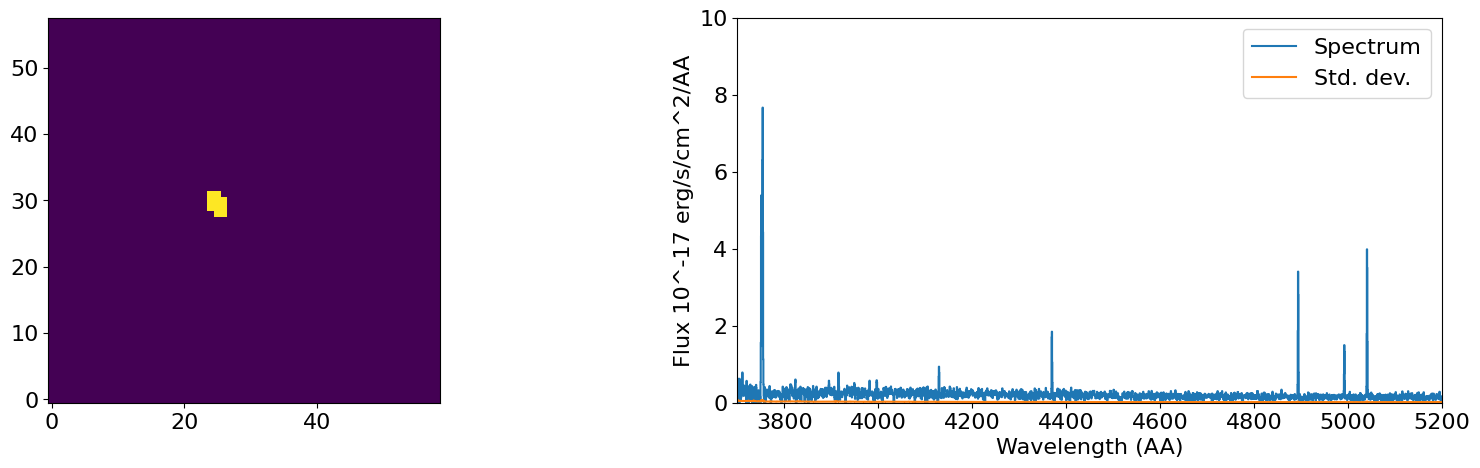

In [41]:
# Get a spectrum at the FRB location
frb_coord = SkyCoord("12h09m44.3126s", "+58d50m56.709s", unit="deg")
sky_aper = SkyEllipticalAperture(frb_coord, a=0.75*u.arcsec, b = 0.4*u.arcsec, theta = 10*u.deg)
pix_aper = sky_aper.to_pixel(oii_img.wcs)

# Make the mask on the same pixel grid
spat_mask = np.zeros(oii_img.shape)
aper_mask = pix_aper.to_mask(method='center')
xmin, xmax, ymin, ymax = aper_mask.bbox.ixmin, aper_mask.bbox.ixmax, aper_mask.bbox.iymin, aper_mask.bbox.iymax  
spat_mask[ymin:ymax, xmin:xmax] = aper_mask.data

plt.rcParams['font.size']=16
fig, axs = plt.subplots(1, 2, figsize=(20,5))

ax = axs[0]
ax.imshow(spat_mask)
ax.invert_yaxis()

# Apply it to the cube to get a spectrum
frb_spec, frb_varspec = blue_cube.spec_from_spatial_mask(spat_mask.astype(bool))
ax = axs[1]
ax.step(blue_cube.cube.spectral_axis.value, frb_spec, label='Spectrum')
ax.step(blue_cube.cube.spectral_axis.value, np.sqrt(frb_varspec), label='Std. dev.')
ax.legend()
ax.set_xlabel("Wavelength (AA)")
ax.set_ylabel("Flux 10^-17 erg/s/cm^2/AA")
ax.set_ylim(0, 10)
ax.set_xlim(3700, 5200)
plt.show()


### Detect sources and get their spectra

In [42]:
# First create a reference image and save it to disk
oii_img.write("oii_img.fits", overwrite=True)

/home/sunil/miniconda3/lib/python3.12/site-packages/astropy/io/fits/card.py:1038: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn(


In [48]:
# Detect sources in the image
objects, segmap = kcwi.find_sources("oii_img.fits", nsig = 5)
objects

thresh,npix,tnpix,xmin,xmax,ymin,ymax,x,y,x2,y2,xy,errx2,erry2,errxy,a,b,theta,cxx,cyy,cxy,cflux,flux,cpeak,peak,xcpeak,ycpeak,xpeak,ypeak,flag
float64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64
5.0,111,109,40,54,11,23,45.42212686438971,12.877479232314295,7.6893736859451,8.542246306222594,3.124235086839729,0.0,0.0,0.0,3.3569352626800537,2.2276909351348877,0.8532255291938782,0.15274828672409058,0.13749763369560242,-0.1117321029305458,4232.6796875,4295.51318359375,136.58059692382812,167.91024780273438,45,13,46,13,1
5.0,32,32,39,44,14,20,41.169810811224266,15.849110790247497,1.8174174820415185,2.450801172303147,0.2589501728354682,0.0,0.0,0.0,1.5947389602661133,1.313402533531189,1.2280842065811157,0.5586414337158203,0.4142664670944214,-0.1180514320731163,1803.470703125,1908.4495849609375,106.41588592529297,135.4991455078125,41,16,41,16,1
5.0,94,93,36,55,2,22,43.512171330919685,6.58100629744075,9.495165253186869,6.285198434347642,2.2668443070064868,0.0,0.0,0.0,3.2661430835723877,2.261121988296509,0.47735223174095154,0.11523928493261337,0.17409411072731018,-0.08312530815601349,5147.78466796875,5350.3173828125,107.06915283203125,121.31420135498047,44,6,45,6,1
5.0,235,229,14,44,20,36,27.470629381108626,27.41720769408835,26.828423284178257,6.633945392114114,2.4972991802233224,0.0,0.0,0.0,5.208902359008789,2.5158908367156982,0.12122970074415207,0.03862743824720383,0.15621371567249298,-0.02908202074468136,5283.2451171875,5301.25341796875,108.41051483154297,135.13455200195312,27,27,26,27,1
5.0,85,82,28,38,29,40,32.995819595275975,32.02487435452376,4.677873557954854,7.523412649822042,-0.8423421284954848,0.0,0.0,0.0,2.7846126556396484,2.1088428497314453,-1.3035218715667725,0.2181709110736847,0.1356533169746399,0.0488540381193161,1929.6953125,1954.6842041015625,74.34085845947266,86.47209167480469,33,32,33,32,1
5.0,225,224,24,49,8,28,31.207212685848408,14.907586601760539,38.11370440394629,28.728774182458096,21.198006772551793,0.0,0.0,0.0,7.425119876861572,3.4219985008239746,0.6764729022979736,0.044499028474092484,0.059035684913396835,-0.06566870957612991,4511.55712890625,4543.3125,55.3096809387207,59.8267707824707,30,13,30,15,1
5.0,188,175,0,22,29,47,7.56934836577072,39.565293900211145,15.63989744549886,10.055094968800944,-5.511585316572322,0.0,0.0,0.0,4.361891269683838,2.582420825958252,-0.5509245991706848,0.07924693077802658,0.12326227873563766,0.08687660098075867,3121.360595703125,3160.17919921875,69.34937286376953,84.3458023071289,8,39,8,39,1


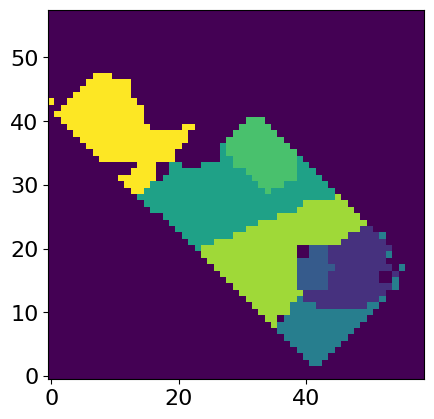

In [50]:
plt.imshow(segmap)
plt.gca().invert_yaxis()
plt.show()